In [ ]:
!git clone https://github.com/AbrahamCamelo/ResearchMethods_GitHub.git

Cloning into 'ResearchMethods_GitHub'...
remote: Enumerating objects: 483, done.
remote: Counting objects: 100% (483/483), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 483 (delta 408), reused 452 (delta 395), pack-reused 0 (from 0)
Receiving objects: 100% (483/483), 2.21 MiB | 8.48 MiB/s, done.
Resolving deltas: 100% (408/408), done.


In [ ]:
!pip install -q -U keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.7 MB/s eta 0:00:00


In [87]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score,root_mean_squared_error
import matplotlib.pyplot as plt

Import the dataset

In [45]:
df_average = pd.read_csv('ResearchMethods_GitHub/ndvi_data/average_ndvi.csv')
df_average['date'] = pd.to_datetime(df_average.date)
df_average = df_average.drop(columns=['Unnamed: 0'])
lst_ndvi = np.array(df_average.NDVI)

In [62]:
n_steps_in = 30
n_steps_out = 1

In [63]:
scaler = MinMaxScaler()
lst_ndvi = scaler.fit_transform(lst_ndvi.reshape(-1, 1))

#### Function to restructure the data for the model

In [64]:
def prepare_data(data, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(data) - n_steps_in - n_steps_out):
        X.append(data[i:i+n_steps_in])
        y.append(data[i+n_steps_in:i+n_steps_in+n_steps_out])
    return np.array(X), np.array(y)

In [65]:
X, y = prepare_data(lst_ndvi, n_steps_in, n_steps_out)

## Keras tune
*   Definition of an integer hyperparameter: hp.Int(*hyperparameter*, min_value=#, max_value=#, step=#). This means that the *hyperparameter* will range from *min_value* to *max_value* inclusive with the minimum step for walking through the interval being *step*.

### Compile
Configures the model for training.

**Hyperparameters**
* **optimizer**: String (name of optimizer) or optimizer instance. Related to back propagation.
* **loss**: Loss function. fn(y_true, y_pred)
* **metrics**: List of metrics to be evaluated by the model during training and testing.

It looks like loss is for the fitting of the model and metrics is for the final evaluation.



In [140]:
def build_model(hp):
    model = Sequential()
    for i in range(hp.Int("num_layers", 1, 3)):
      model.add(
          LSTM(units=hp.Int(f"units_{i}", min_value=10, max_value=100, step=10),
              activation='tanh',
              input_shape=(n_steps_in, 1) if i == 0 else None,
               return_sequences =(i < hp.get("num_layers") - 1)
              )
          )
    model.add(Dense(n_steps_out))
    model.compile(
        optimizer= Adam(learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")),
        loss='mean_squared_error',
        metrics = ['root_mean_squared_error']
    )
    return model

### To initialize the tuner

* **hypermodel**. The model-building function, which is build_model in our case.
* **objective**. The name of the objective to optimize.
* **max_trials**. The total number of trials to run during the search. Different trials have different hyperparameter values.
* **executions_per_trial**. The number of models that should be built and fit for each trial. It is like cross-validation.
* **overwrite**. Control whether to overwrite the previous results in the same directory or resume the previous search instead.
* **directory**. A path to a directory for storing the search results.
* **project_name**. The name of the sub-directory in the directory.

In [142]:
!rm -rf /content/lstm_tuning

In [143]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=30,
    executions_per_trial=3,
    directory='lstm_tuning',
    project_name='time_series_forecasting'
)
tuner.search_space_summary()

Search space summary
Default search space size: 3
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 100, 'step': 10, 'sampling': 'linear'}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [144]:
split = int(0.8 * len(X))
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]
X_train.shape

(85, 30, 1)

In [145]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
tuner.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stop])

Trial 30 Complete [00h 00m 30s]
val_loss: 0.02148790347079436

Best val_loss So Far: 0.018751021474599838
Total elapsed time: 00h 17m 24s


Show the sumary of the results

In [146]:
tuner.results_summary()


Results summary
Results in lstm_tuning/time_series_forecasting
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 15 summary
Hyperparameters:
num_layers: 1
units_0: 60
lr: 0.006429326855520711
units_1: 20
units_2: 100
Score: 0.018751021474599838

Trial 14 summary
Hyperparameters:
num_layers: 1
units_0: 40
lr: 0.004127702183794183
units_1: 60
units_2: 10
Score: 0.018812987332542736

Trial 19 summary
Hyperparameters:
num_layers: 1
units_0: 40
lr: 0.000508254369808113
units_1: 20
units_2: 70
Score: 0.020082493002216022

Trial 27 summary
Hyperparameters:
num_layers: 2
units_0: 60
lr: 0.004918860745687648
units_1: 60
units_2: 90
Score: 0.02038283459842205

Trial 25 summary
Hyperparameters:
num_layers: 2
units_0: 100
lr: 0.0026263512824869465
units_1: 90
units_2: 50
Score: 0.020583937565485638

Trial 20 summary
Hyperparameters:
num_layers: 1
units_0: 100
lr: 0.000250228668797638
units_1: 60
units_2: 80
Score: 0.020692937076091766

Trial 12 summary
Hyperparameters:
num_

Best result so far:
* units: 40
* lr: 0.00976844384018483
* Score: 0.01515659037977457

In [147]:
tuner.get_best_hyperparameters(5)[0].values

{'num_layers': 1,
 'units_0': 60,
 'lr': 0.006429326855520711,
 'units_1': 20,
 'units_2': 100}

In [148]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.fit(X, y, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stop])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - loss: 0.0293 - root_mean_squared_error: 0.1697 - val_loss: 0.0155 - val_root_mean_squared_error: 0.1245
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0288 - root_mean_squared_error: 0.1697 - val_loss: 0.0172 - val_root_mean_squared_error: 0.1311
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0195 - root_mean_squared_error: 0.1397 - val_loss: 0.0203 - val_root_mean_squared_error: 0.1424
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0174 - root_mean_squared_error: 0.1317 - val_loss: 0.0157 - val_root_mean_squared_error: 0.1254
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0177 - root_mean_squared_error: 0.1322 - val_loss: 0.0165 - val_root_mean_squared_error: 0.1286
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0141 - root_mean_squared_error: 0.1187 - val_loss: 0.0154 - val_root_mean_squared_error: 0.1243
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0126 - root_mean_squa

In [149]:
def forecast(model, input_sequence, n_steps_out):
    input_sequence = input_sequence.reshape((1, n_steps_in, 1))
    predictions = model.predict(input_sequence)
    return predictions[0]

In [150]:
input_sequence = lst_ndvi[-n_steps_in:]
predictions = forecast(best_model, input_sequence, n_steps_out)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))

print("Predictions for the next 6 steps:", predictions.flatten())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
Predictions for the next 6 steps: [0.04911879]


In [151]:
print(root_mean_squared_error(y.flatten(), best_model.predict(X).flatten()))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  
0.09247472722595848


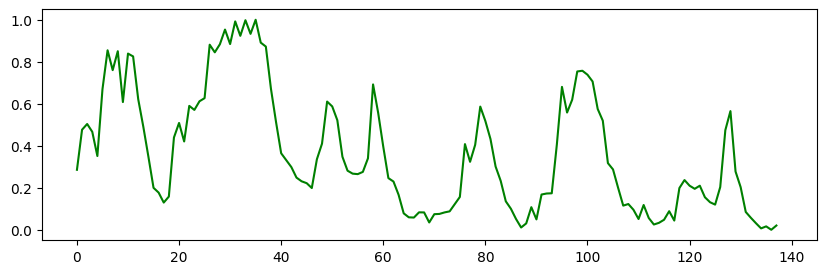

In [152]:
plt.figure(figsize=(10,3))
plt.plot(range(len(lst_ndvi),len(lst_ndvi)+len(predictions)), predictions, label = 'Predicted', c = 'orange')
plt.plot(lst_ndvi, label = 'Predicted', c = 'green')
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


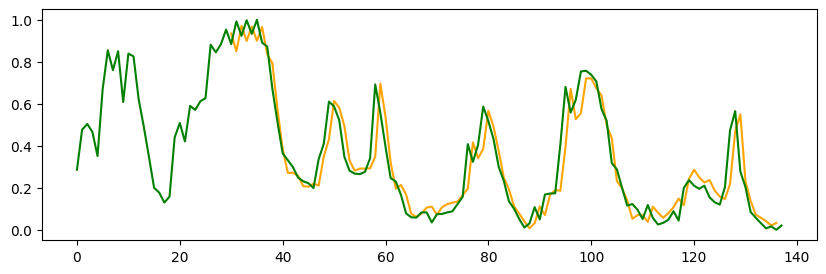

In [153]:
Total_pred = best_model.predict(X)
plt.figure(figsize=(10,3))
plt.plot(range(len(lst_ndvi)-len(Total_pred)-1,len(lst_ndvi)-1),Total_pred, label = 'Predicted', c = 'orange')
plt.plot(lst_ndvi, label = 'Predicted', c = 'green')
#plt.plot(np.concatenate((lst_ndvi,predictions)), label = 'Predicted', c = 'green')
plt.show()